In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from dask.distributed import Client

In [2]:
client = Client()
auth = earthaccess.login("../login.netrc")

In [16]:
# --- TIME ---

tspan = ("2024-09-01 00:00", "2025-03-01 00:00")

# --- REGION ---

# 42.69174831596751, 21.058555012396997
region = (41.7, 20.36, 43.7, 22.06)
mid = (21.058555012396997, 42.69174831596751)
ext = 1
region = (mid[0] - ext , mid[1] - ext, mid[0] + ext, mid[1] + ext)
region

(20.058555012396997, 41.69174831596751, 22.058555012396997, 43.69174831596751)

In [ ]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AER_UAA",
    # Note that NRT (near real time) has less data
    #!! short_name="PACE_OCI_L2_AER_UAA",
    #! short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
    cloud_hosted=True,
    bounding_box=region,
    temporal=tspan,
)
print(len(results))

286


In [19]:

def get_wv_idx(path, wv):
    dt = xr.open_datatree(path)
    return dt["sensor_band_parameters"].wavelength3d.get_index("wavelength3d").get_loc(wv)

def time_from_attr(ds):
    """Set the start time attribute as a dataset variable.

    Parameters
    ----------
    ds
        a dataset corresponding to a Level-2 granule
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds

def grid_match(path, dst_crs, dst_shape, dst_transform, var, wv_idx=None):
    geoloc_group_name = 'geolocation_data'
    
    """Reproject a Level-2 granule to match a Level-3M-ish granule."""
    dt = xr.open_datatree(path)
   
    
    if "geophysical_data" in dt:
        da = dt["geophysical_data"]
    elif "navigation_data" in dt:
        da = dt["navigation_data"]
    else:
        da = None  # or raise an error / handle differently
        
        
    da = da[var]
    if wv_idx is not None:
        if "wavelength3d" in da.dims:
            da = da.sel(wavelength3d=wv_idx)
        elif "Wavelength_Used_all" in da.dims:
            da = da.sel(Wavelength_Used_all=wv_idx)
        else:
            raise KeyError("Neither 'wavelength3d' nor 'Wavelength_Used_all' found in dataset.")
    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.set_crs("epsg:4326")
    da = da.rio.reproject(
        dst_crs,
        shape=dst_shape,
        transform=dst_transform,
        src_geoloc_array=(
            dt[geoloc_group_name]["longitude"],
            dt[geoloc_group_name]["latitude"],
        ),
    )
    da = da.rename({"x":"longitude", "y":"latitude"})
    return da

def crs_template(path, var, wv=None):
    datatree = xr.open_datatree(path)

    dataset = xr.merge(datatree.to_dict().values())
    dataset = dataset.set_coords(("latitude", "longitude"))
    da = dataset[var]
    if wv is not None:
        if "wavelength3d" in da.dims:
            da = da.sel(wavelength3d=wv)
        elif "Wavelength_Used_all" in da.dims:
            da = da.sel(Wavelength_Used_all=wv)
        else:
            raise KeyError("Neither 'wavelength3d' nor 'Wavelength_Used_all' found in dataset.")

    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.write_crs("epsg:4326")
    da_L3M = da.rio.reproject(
        dst_crs="epsg:4326",
        src_geoloc_array=(
            da.coords["longitude"],
            da.coords["latitude"],
        ),
    )
    da_L3M = da_L3M.rename({"x":"longitude", "y":"latitude"})
    return da_L3M.rio.crs, da_L3M.rio.shape, da_L3M.rio.transform()

def grid_aligned_subset(bbox, transform, shape):
    from affine import Affine
    """
    mid: (lon, lat)
    ext: half-size in degrees (so box is lon±ext, lat±ext)
    transform: source Affine from crs_template
    shape: (height, width) from crs_template
    returns: (new_shape, new_transform, window_indices)
    """
    height, width = shape
    lon_min, lat_min, lon_max, lat_max = bbox

    # Map bounds to fractional pixel indices on the source grid
    inv = ~transform
    # upper-left of box -> (col,row)
    c0, r0 = inv * (lon_min, lat_max)
    # lower-right of box -> (col,row)
    c1, r1 = inv * (lon_max, lat_min)

    # Snap to integer pixel edges (expand to cover the whole region)
    col_off = int(np.floor(c0))
    row_off = int(np.floor(r0))
    col_max = int(np.ceil(c1))
    row_max = int(np.ceil(r1))

    # Clamp the *max* values, not the offsets
    print(col_off)
    #col_off = max(col_off, 0)
    #row_off = max(row_off, 0)
    #col_max = min(col_max, width)
    #row_max = min(row_max, height)

    cols = max(0, col_max - col_off)
    rows = max(0, row_max - row_off)

    # New transform is the old one shifted by the window offset
    new_transform = transform * Affine.translation(col_off, row_off)
    new_shape = (rows, cols)

    # Window indices you can use to slice arrays
    window = dict(row_off=row_off, col_off=col_off, height=rows, width=cols)
    return new_shape, new_transform, window


In [ ]:
results = earthaccess.search_data(
    #! short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
    short_name="PACE_OCI_L2_AER_UAA",
    temporal=tspan,
    bounding_box=region
)
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/286 [00:00<?, ?it/s]

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240901T110154.L2.AER_UAA.V3_1.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240902T095803.L2.AER_UAA.V3_1.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240902T113620.L2.AER_UAA.V3_1.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240903T103227.L2.AER_UAA.V3_1.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240903T121044.L2.AER_UAA.V3_1.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240904T110650.L2.AER_UAA.V3_1.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240905T100256.L2.AER_UAA.V3_1.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240905T114113.L2.AER_UAA.V3_1.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240906T103719.L2.AER_UAA.V3_1.nc>, <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240907T111142.L2.AER_UAA

In [21]:
wv = 550
#! wv_idx = get_wv_idx(paths[0], wv)
wv_idx = 550
#! crs, shape_tmp, transform_tmp = crs_template(paths[0], "aot", wv)
crs, shape_tmp, transform_tmp = crs_template(paths[0], "Aerosol_Optical_Depth", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = grid_aligned_subset(region, transform_tmp, shape_tmp)
print(shape)
print(transform)

161
(19, 18)
| 0.11, 0.00, 20.05|
| 0.00,-0.12, 43.78|
| 0.00, 0.00, 1.00|


In [22]:

kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
futures = client.map(
    grid_match,
    paths,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="Aerosol_Optical_Depth",
    #! var="aot",
    wv_idx=wv_idx
)
da = xr.combine_nested(client.gather(futures), concat_dim="time")
da ["time"] = attrs["time"]

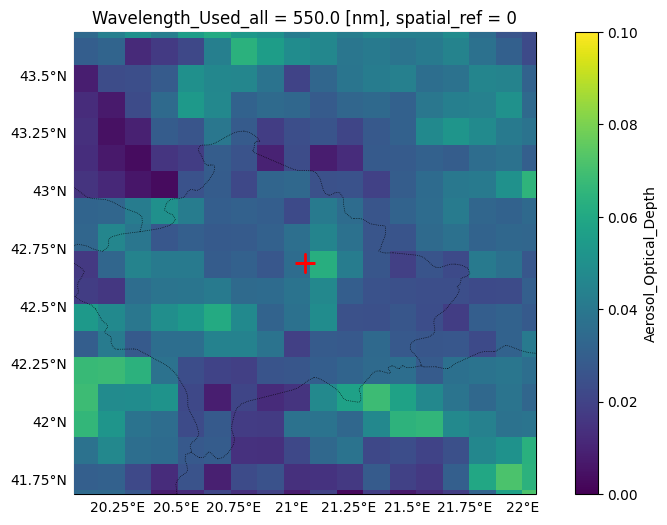

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

cross_lonlat=(21.058555012396997, 42.69174831596751)


da_mean = da.mean("time")
fig, ax_map = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(10, 6)
)
tiler = cimgt.GoogleTiles(style='satellite')
# --- Map ---
#ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax_map.set_extent([region[0], region[2], region[1], region[3]], crs=ccrs.PlateCarree())
ax_map.add_image(tiler, 12)   # zoom controls resolution

# optional political/land features on top of basemap
ax_map.coastlines(resolution="110m", color="black", linewidth=0.6, zorder=2)
ax_map.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5, zorder=4)
ax_map.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.2, zorder=1)

da_mean.plot.imshow(
    ax=ax_map,
    transform=ccrs.PlateCarree(),  # needed so data is placed correctly
    robust=True,
    cmap="viridis",                 # choose colormap if you like
    vmin=0.0,
    vmax=0.1,
    zorder=3
)

gl = ax_map.gridlines(draw_labels=True, linestyle="--")
gl.top_labels = False
gl.right_labels = False

cln, clt = cross_lonlat
ax_map.plot(
    cln, clt, transform=ccrs.PlateCarree(),
    marker="+", markersize=14, mew=2, mec="red", mfc="none",
    linestyle="none", zorder=4
)
plt.show()